In [1]:
!pip install qdrant-client tqdm rich transformers torch sentence-transformers matplotlib scikit-learn plotly nbformat>=4.2.0

# Imports

In [2]:
import os
import json
import time
import uuid
import string
import re
import nltk
import numpy as np
import torch
from tqdm import tqdm
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest
from rich import print
from rich.console import Console
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import plotly.express as px

# Initialize Qdrant client and console

In [3]:
client = QdrantClient("localhost", port=6333)
console = Console()

# Download NLTK stopwords

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Initialize the tokenizer and model

In [5]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [6]:
def preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    tokens = text.split()
    stopwords_set = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stopwords_set]
    return ' '.join(tokens)

def preprocess_title(title: str) -> str:
    """Remove the year from the movie title."""
    return re.sub(r"\(\d{4}\)$", "", title).strip()

In [7]:
def create_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

In [8]:
def normalize_embeddings(embeddings):
    """Normalize the embeddings to unit vectors."""
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norms
    return normalized_embeddings

In [9]:
def encode_id(original_id):
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, original_id))

In [10]:
def load_movies_data(file_path):
    if not os.path.exists(file_path):
        console.print(f"[red]File not found: {file_path}[/red]")
        return None

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            movies = json.load(f)
        return movies["films"]["film"]
    except Exception as e:
        console.print(f"[red]Error reading the movies.json file: {e}[/red]")
        return None

In [11]:
def process_movies_data(movies):
    movies_data = []
    for movie in movies:
        roles = movie.get("role", [])
        if isinstance(roles, dict):
            roles = [roles]

        actors = [role.get("acteur", {}).get("__text", "") for role in roles]

        movie_id = movie.get("id", "") or encode_id(movie['titre'])

        movies_data.append({
            "title": movie.get("titre", ""),
            "year": movie.get("annee", ""),
            "country": movie.get("pays", ""),
            "language": movie.get("langue", ""),
            "duration": movie.get("duree", ""),
            "summary": movie.get("synopsis", ""),
            "genre": movie.get("genre", ""),
            "director": movie.get("realisateur", {"__text": ""}).get("__text", ""),
            "writers": movie.get("scenariste", []),
            "actors": actors,
            "poster": movie.get("affiche", ""),
            "id": movie_id
        })
    return movies_data

In [12]:
def upsert_movies_to_qdrant(client, movies_data, batch_size=100):
    client.recreate_collection(
        collection_name="testings",
        vectors_config=rest.VectorParams(size=384, distance=rest.Distance.COSINE)
    )

    points = []
    total_movies = len(movies_data)
    console.print(f"Total movies to process: {total_movies}")

    start_time = time.time()

    for idx, movie in tqdm(enumerate(movies_data), total=total_movies, desc="Processing movies"):
        try:
            combined_info = f"{movie['title']} {movie['year']} {movie['country']} {movie['language']} {movie['duration']} {movie['summary']} {movie['genre']} {' '.join(movie['actors'])} {movie['director']} {' '.join(movie['writers'])}"
            combined_info = ' '.join(combined_info.split())
            combined_info = preprocess(combined_info)
            vector = create_embedding(combined_info)
            vector = normalize_embeddings(np.array([vector]))[0]
            point = {
                'id': str(uuid.uuid4()),
                'vector': vector.tolist(),
                'payload': {
                    'title': movie['title'],
                    'year': movie['year'],
                    'country': movie['country'],
                    'language': movie['language'],
                    'duration': movie['duration'],
                    'summary': movie['summary'],
                    'genre': movie['genre'],
                    'director': movie['director'],
                    'writers': movie['writers'],
                    'actors': ', '.join(movie['actors']),
                    'poster': movie['poster']
                }
            }
            points.append(point)

            if len(points) >= batch_size:
                client.upsert(collection_name="testings", points=points)
                console.print(f"Upserted {len(points)} movies to Qdrant")
                points.clear()

        except Exception as e:
            console.print(f"[red]Error processing movie ID {movie['id']}: {e}[/red]")

    if points:
        client.upsert(collection_name="testings", points=points)
        console.print(f"Upserted remaining {len(points)} movies to Qdrant")

    elapsed_time = time.time() - start_time
    console.print(f"Movies loaded into Qdrant with embeddings in {elapsed_time:.2f} seconds")


In [13]:
# Main script execution
current_directory = os.getcwd()
movies_file_path = os.path.join(current_directory, "movies.json")

console.print("[green]Loading movies data...[/green]")
movies = load_movies_data(movies_file_path)

if movies:
    console.print("[green]Processing movies data...[/green]")
    movies_data = process_movies_data(movies)
    console.print("[green]Upserting movies data to Qdrant...[/green]")
    upsert_movies_to_qdrant(client, movies_data)

Loading movies data...

Processing movies data...

Upserting movies data to Qdrant...

C:\Users\antoi\AppData\Local\Temp\ipykernel_12016\2249141115.py:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Total movies to process: 631

Processing movies:  16%|█▌        | 98/631 [00:04<00:14, 35.80it/s]

Upserted 100 movies to Qdrant

Processing movies:  31%|███▏      | 198/631 [00:07<00:12, 34.04it/s]

Upserted 100 movies to Qdrant

Processing movies:  47%|████▋     | 296/631 [00:09<00:09, 34.59it/s]

Upserted 100 movies to Qdrant

Processing movies:  63%|██████▎   | 396/631 [00:12<00:06, 34.36it/s]

Upserted 100 movies to Qdrant

Processing movies:  79%|███████▉  | 499/631 [00:15<00:03, 36.48it/s]

Upserted 100 movies to Qdrant

Processing movies:  95%|█████████▍| 597/631 [00:18<00:01, 34.00it/s]

Upserted 100 movies to Qdrant

Processing movies: 100%|██████████| 631/631 [00:19<00:00, 32.09it/s]


Upserted remaining 31 movies to Qdrant

Movies loaded into Qdrant with embeddings in 19.69 seconds

In [14]:
def get_movie_embedding(movie_description):
    # Preprocess the input text
    processed_text = preprocess(movie_description)

    # Generate embedding
    embedding = create_embedding(processed_text)
    return normalize_embeddings(np.array([embedding]))[0]

In [15]:
def find_similar_movies(client, movie_description, top_k=5):
    embedding = get_movie_embedding(movie_description)

    search_result = client.search(
        collection_name="testings",
        query_vector=embedding.tolist(),
        limit=top_k
    )
    return search_result

In [16]:
def display_similar_movies(client, movie_description, top_k=5):
    results = find_similar_movies(client, movie_description, top_k)

    console.print(f"\n[bold]Query Movie Description:[/bold] {movie_description}")
    console.print(f"\n[bold]Top {top_k} Similar Movies:[/bold]\n")

    for idx, result in enumerate(results):
        movie_info = result.payload
        console.print(f"[bold]{idx + 1}. Title:[/bold] {movie_info['title']}")
        console.print(f"   [bold]Year:[/bold] {movie_info['year']}")
        console.print(f"   [bold]Genre:[/bold] {movie_info['genre']}")
        console.print(f"   [bold]Director:[/bold] {movie_info['director']}")
        console.print(f"   [bold]Summary:[/bold] {movie_info['summary']}\n")

# Example usage
movie_description = "A story about a young boy who discovers he has magical powers and attends a school for wizards."
display_similar_movies(client, movie_description)

Query Movie Description: A story about a young boy who discovers he has magical powers and attends a school for 
wizards.

Top 5 Similar Movies:

1. Title: Harry Potter and the Sorcerer's Stone

Year: 2001

Genre: ['Adventure', 'Family', 'Fantasy']

Director: Chris Columbus

Summary:

2. Title: Harry Potter and the Half-Blood Prince

Year: 2009

Genre: ['Action', 'Adventure', 'Family', 'Fantasy', 'Mystery', 'Romance']

Director: David Yates

Summary:

3. Title: Harry Potter and the Goblet of Fire

Year: 2005

Genre: ['Adventure', 'Family', 'Fantasy', 'Mystery']

Director: Mike Newell

Summary:

4. Title: Harry Potter and the Chamber of Secrets

Year: 2002

Genre: ['Adventure', 'Family', 'Fantasy', 'Mystery']

Director: Chris Columbus

Summary:

5. Title: Harry Potter and the Prisoner of Azkaban

Year: 2004

Genre: ['Adventure', 'Family', 'Fantasy', 'Mystery']

Director: Alfonso Cuarón

Summary:

In [17]:
def extract_all_embeddings(client, collection_name="testings"):
    all_vectors = []
    all_titles = []
    limit = 100  # Number of points to fetch per request
    offset = None  # Initial offset for scrolling

    while True:
        points, next_page_offset = client.scroll(
            collection_name=collection_name,
            scroll_filter=None,
            limit=limit,
            with_payload=True,
            with_vectors=True,
            offset=offset
        )

        if not points:
            break

        for point in points:
            all_vectors.append(point.vector)
            all_titles.append(point.payload['title'])

        offset = next_page_offset
        if offset is None:
            break

    return np.array(all_vectors), all_titles

In [18]:
def reduce_dimensions(vectors, method='tsne', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
    else:
        raise ValueError("Method should be either 'pca' or 'tsne'.")

    return reducer.fit_transform(vectors)

In [19]:
def plot_embeddings(reduced_vectors, titles, method='t-SNE'):
    plt.figure(figsize=(14, 10))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)

    # Optionally, annotate a few points to verify correctness
    for i in range(0, len(titles), max(1, len(titles)//20)):  # Annotate 20 points
        plt.annotate(titles[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]))

    plt.title(f'Movie Embeddings Visualized with {method}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Extract all embeddings and titles

In [20]:
vectors, titles = extract_all_embeddings(client)

# Reduce dimensions using t-SNE (or PCA)

In [21]:
reduced_vectors = reduce_dimensions(vectors, method='tsne')

# Plot the reduced embeddings

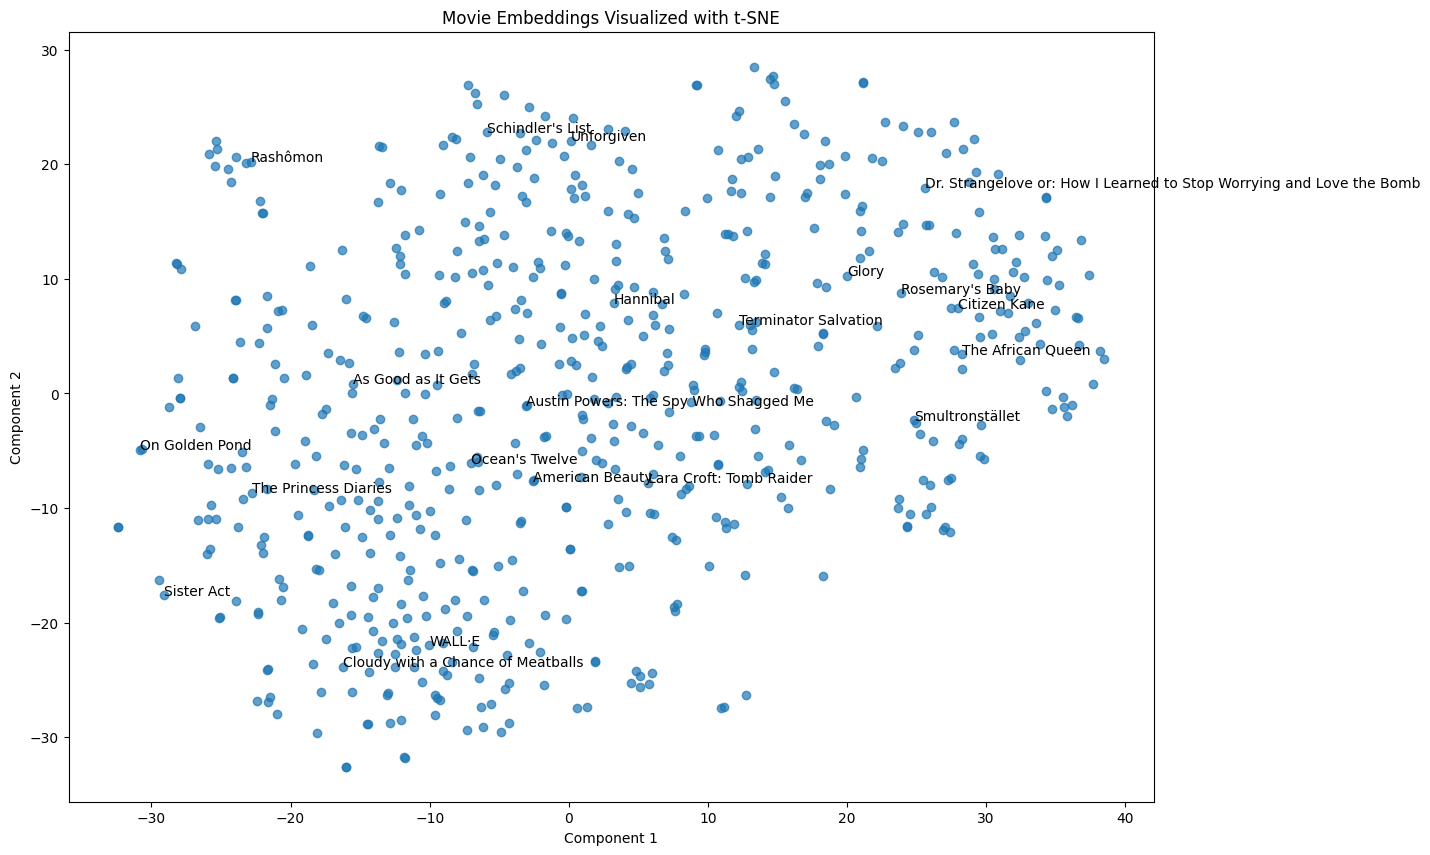

In [22]:
plot_embeddings(reduced_vectors, titles, method='t-SNE')

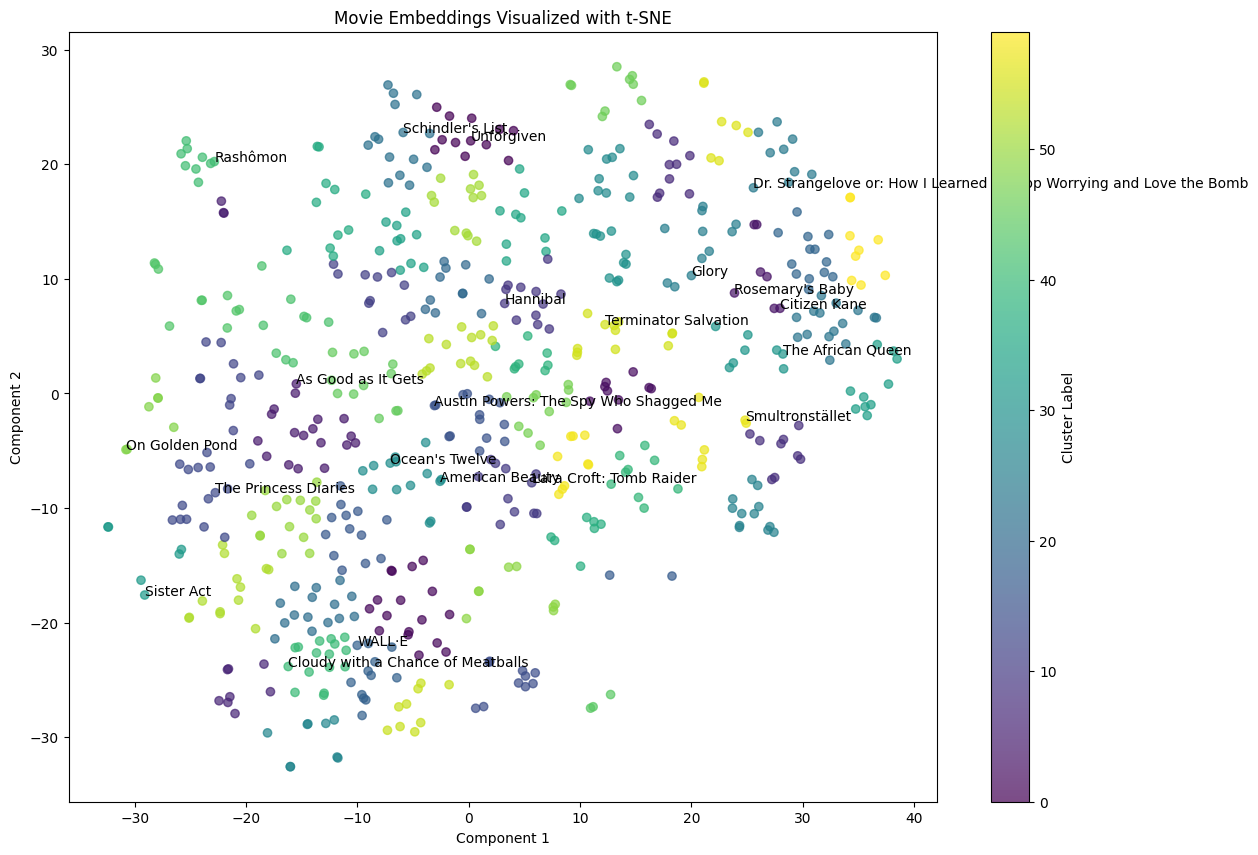

In [23]:
def apply_kmeans(reduced_vectors, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_vectors)
    return kmeans.labels_

# Apply KMeans clustering
n_clusters = 60
cluster_labels = apply_kmeans(reduced_vectors, n_clusters)

# Plot the reduced embeddings with cluster labels
def plot_clusters(reduced_vectors, titles, cluster_labels, method='t-SNE'):
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

    # Optionally, annotate a few points to verify correctness
    for i in range(0, len(titles), max(1, len(titles)//20)):  # Annotate 20 points
        plt.annotate(titles[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]))

    plt.title(f'Movie Embeddings Visualized with {method}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

# Plot the clusters
plot_clusters(reduced_vectors, titles, cluster_labels, method='t-SNE')

In [24]:
def plot_clusters_interactive(reduced_vectors, titles, cluster_labels, method='t-SNE'):
    fig = px.scatter(
        x=reduced_vectors[:, 0],
        y=reduced_vectors[:, 1],
        color=cluster_labels.astype(str),
        hover_name=titles,
        labels={'x': 'Component 1', 'y': 'Component 2', 'color': 'Cluster Label'},
        title=f'Movie Embeddings Visualized with {method}'
    )
    fig.update_layout(width=800, height=600)
    fig.show()

# Plot the clusters interactively
plot_clusters_interactive(reduced_vectors, titles, cluster_labels, method='t-SNE')